In [16]:
# Imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from pytorch_metric_learning import losses, samplers
from random import randint
from skimage import io, transform
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data.sampler import Sampler
from torchvision import datasets, models, transforms

In [17]:
# Configurations
# Device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Num epochs
num_epochs = 25

# Model 
model = models.resnet50()
dfnet_model = models.resnet18()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Batch size
batch_size = 32

# Data set
train_path = '/lab/vislab/DATA/CUB/images/'

# Loss function
criterion = losses.TripletMarginLoss(margin=0.1)

In [18]:
class RandomMask(object):
    """Add random occlusions to image.

    Args:
        mask: (Image.Image) - Image to use to occlude.
    """

    def __init__(self, mask):
        assert isinstance(mask, Image.Image)
        self.mask = mask

    def __call__(self, sample):                    
        self.mask = self.mask.resize((64,64))
        theta = randint(0,45)
        self.mask = self.mask.rotate(angle=theta)
        seed_x = randint(1,10)
        seed_y = randint(1,10)
        sample.paste(self.mask, (20*seed_x, 20*seed_y))

        return sample

In [19]:
# DF-Net
import torch.nn.functional as F

def get_norm(name, out_channels):
    if name == 'batch':
        norm = nn.BatchNorm2d(out_channels)
    elif name == 'instance':
        norm = nn.InstanceNorm2d(out_channels)
    else:
        norm = None
    return norm


def get_activation(name):
    if name == 'relu':
        activation = nn.ReLU()
    elif name == 'elu':
        activation == nn.ELU()
    elif name == 'leaky_relu':
        activation = nn.LeakyReLU(negative_slope=0.2)
    elif name == 'tanh':
        activation = nn.Tanh()
    elif name == 'sigmoid':
        activation = nn.Sigmoid()
    else:
        activation = None
    return activation


class Conv2dSame(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()

        padding = self.conv_same_pad(kernel_size, stride)
        if type(padding) is not tuple:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding)
        else:
            self.conv = nn.Sequential(
                nn.ConstantPad2d(padding*2, 0),
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, 0)
            )

    def conv_same_pad(self, ksize, stride):
        if (ksize - stride) % 2 == 0:
            return (ksize - stride) // 2
        else:
            left = (ksize - stride) // 2
            right = left + 1
            return left, right

    def forward(self, x):
        return self.conv(x)


class ConvTranspose2dSame(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()

        padding, output_padding = self.deconv_same_pad(kernel_size, stride)
        self.trans_conv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride,
            padding, output_padding)

    def deconv_same_pad(self, ksize, stride):
        pad = (ksize - stride + 1) // 2
        outpad = 2 * pad + stride - ksize
        return pad, outpad

    def forward(self, x):
        return self.trans_conv(x)


class UpBlock(nn.Module):

    def __init__(self, mode='nearest', scale=2, channel=None, kernel_size=4):
        super().__init__()

        self.mode = mode
        if mode == 'deconv':
            self.up = ConvTranspose2dSame(
                channel, channel, kernel_size, stride=scale)
        else:
            def upsample(x):
                return F.interpolate(x, scale_factor=scale, mode=mode)
            self.up = upsample

    def forward(self, x):
        return self.up(x)


class EncodeBlock(nn.Module):

    def __init__(
            self, in_channels, out_channels, kernel_size, stride,
            normalization=None, activation=None):
        super().__init__()

        self.c_in = in_channels
        self.c_out = out_channels

        layers = []
        layers.append(
            Conv2dSame(self.c_in, self.c_out, kernel_size, stride))
        if normalization:
            layers.append(get_norm(normalization, self.c_out))
        if activation:
            layers.append(get_activation(activation))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class DecodeBlock(nn.Module):

    def __init__(
            self, c_from_up, c_from_down, c_out, mode='nearest',
            kernel_size=4, scale=2, normalization='batch', activation='relu'):
        super().__init__()

        self.c_from_up = c_from_up
        self.c_from_down = c_from_down
        self.c_in = c_from_up + c_from_down
        self.c_out = c_out

        self.up = UpBlock(mode, scale, c_from_up, kernel_size=scale)

        layers = []
        layers.append(
            Conv2dSame(self.c_in, self.c_out, kernel_size, stride=1))
        if normalization:
            layers.append(get_norm(normalization, self.c_out))
        if activation:
            layers.append(get_activation(activation))
        self.decode = nn.Sequential(*layers)

    def forward(self, x, concat=None):
        out = self.up(x)
        if self.c_from_down > 0:
            out = torch.cat([out, concat], dim=1)
        out = self.decode(out)
        return out


class BlendBlock(nn.Module):

    def __init__(
            self, c_in, c_out, ksize_mid=3, norm='batch', act='leaky_relu'):
        super().__init__()
        c_mid = max(c_in // 2, 32)
        self.blend = nn.Sequential(
            Conv2dSame(c_in, c_mid, 1, 1),
            get_norm(norm, c_mid),
            get_activation(act),
            Conv2dSame(c_mid, c_out, ksize_mid, 1),
            get_norm(norm, c_out),
            get_activation(act),
            Conv2dSame(c_out, c_out, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.blend(x)


class FusionBlock(nn.Module):
    def __init__(self, c_feat, c_alpha=1):
        super().__init__()
        c_img = 3
        self.map2img = nn.Sequential(
            Conv2dSame(c_feat, c_img, 1, 1),
            nn.Sigmoid())
        self.blend = BlendBlock(c_img*2, c_alpha)

    def forward(self, img_miss, feat_de):
        img_miss = resize_like(img_miss, feat_de)
        raw = self.map2img(feat_de)
        alpha = self.blend(torch.cat([img_miss, raw], dim=1))
        result = alpha * raw + (1 - alpha) * img_miss
        return result, alpha, raw
    
    def resize_like(x, target, mode='bilinear'):
        return F.interpolate(x, target.shape[-2:], mode=mode, align_corners=False)


class DFNet(nn.Module):
    def __init__(
            self, c_img=3, c_mask=1, c_alpha=3,
            mode='nearest', norm='batch', act_en='relu', act_de='leaky_relu',
            en_ksize=[7, 5, 5, 3, 3, 3, 3, 3], de_ksize=[3]*8,
            blend_layers=[0, 1, 2, 3, 4, 5]):
        super().__init__()

        c_init = c_img + c_mask

        self.n_en = len(en_ksize)
        self.n_de = len(de_ksize)
        assert self.n_en == self.n_de, (
            'The number layer of Encoder and Decoder must be equal.')
        assert self.n_en >= 1, (
            'The number layer of Encoder and Decoder must be greater than 1.')

        assert 0 in blend_layers, 'Layer 0 must be blended.'

        self.en = []
        c_in = c_init
        self.en.append(
            EncodeBlock(c_in, 64, en_ksize[0], 2, None, None))
        for k_en in en_ksize[1:]:
            c_in = self.en[-1].c_out
            c_out = min(c_in*2, 512)
            self.en.append(EncodeBlock(
                c_in, c_out, k_en, stride=2,
                normalization=norm, activation=act_en))

        # register parameters
        for i, en in enumerate(self.en):
            self.__setattr__('en_{}'.format(i), en)

        self.de = []
        self.fuse = []
        for i, k_de in enumerate(de_ksize):

            c_from_up = self.en[-1].c_out if i == 0 else self.de[-1].c_out
            c_out = c_from_down = self.en[-i-1].c_in
            layer_idx = self.n_de - i - 1

            self.de.append(DecodeBlock(
                c_from_up, c_from_down, c_out, mode, k_de, scale=2,
                normalization=norm, activation=act_de))
            if layer_idx in blend_layers:
                self.fuse.append(FusionBlock(c_out, c_alpha))
            else:
                self.fuse.append(None)

        # register parameters
        for i, de in enumerate(self.de[::-1]):
            self.__setattr__('de_{}'.format(i), de)
        for i, fuse in enumerate(self.fuse[::-1]):
            if fuse:
                self.__setattr__('fuse_{}'.format(i), fuse)

    def forward(self, img_miss, mask):

        out = torch.cat([img_miss, mask], dim=1)

        out_en = [out]
        for encode in self.en:
            out = encode(out)
            out_en.append(out)

        results = []
        alphas = []
        raws = []
        for i, (decode, fuse) in enumerate(zip(self.de, self.fuse)):
            out = decode(out, out_en[-i-2])
            if fuse:
                result, alpha, raw = fuse(img_miss, out)
                results.append(result)
                alphas.append(alpha)
                raws.append(raw)

        return results[::-1], alphas[::-1], raws[::-1]

In [ ]:
# DF-Net outputs
# TODO: implement this

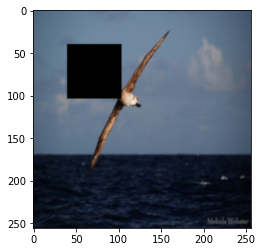

In [20]:
# Dataset

# occlusion transform?
mask = Image.open('/lab/vislab/DATA/masks/mask.png')

transformations = transforms.Compose([
    transforms.Resize((256,256)),
    RandomMask(mask), 
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(train_path, transformations)

plt.imshow(transforms.ToPILImage()(dataset[3][0]), interpolation="bicubic")

train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1033])

In [21]:
# DF-Net Train Loop 
def train_dfnet():
    """Generic function to train model"""
    
    print("Training model ...")

    start_time = datetime.now()
    loss_values = []
    num_batches = 0 
    
    # Epochs 
    for epoch in range(num_epochs): 
        print("epoch num:", epoch)
        
        # *** move this into the batch, too? ***
        train_sampler = torch.utils.data.RandomSampler(train_set)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
        
        running_outputs = torch.FloatTensor().cpu()
        running_labels = torch.LongTensor().cpu()
        running_loss = 0.0
        dfnet_model.train()
        
        # Batches
        for batch_idx, (inputs, labels) in enumerate(train_loader):  
            
            # *** put the DF-Net call here on this call ***
            
            
            num_batches += 1
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            output = dfnet_model.forward(inputs)
            
            running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
            running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)

            loss = criterion(output, labels)
            loss = Variable(loss, requires_grad = True)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Loss Plot            
        loss_values.append(running_loss / num_batches)

        time_elapsed = datetime.now() - start_time 
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

    plt.plot(loss_values)    
    return dfnet_model, running_loss

In [22]:
from sklearn.manifold import TSNE

def map_features(outputs, labels, out_file):
    # create array of column for each feature output
    feat_cols = ['feature'+str(i) for i in range(outputs.shape[1])]
    # make dataframe of outputs -> labels
    df = pd.DataFrame(outputs, columns=feat_cols)
    df['y'] = labels
    df['labels'] = df['y'].apply(lambda i: str(i))
    # clear outputs and labels
    outputs, labels = None, None
    # creates an array of random indices from size of outputs
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    num_examples = 3000
    df_subset = df.loc[rndperm[:num_examples],:].copy()
    data_subset = df_subset[feat_cols].values
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    plt.scatter(
        x=df_subset["tsne-2d-one"],
        y=df_subset["tsne-2d-two"],
        c=df_subset["y"],
        s=3
    )
    plt.savefig(out_file, bbox_inches='tight', pad_inches = 0)
    plt.close()

In [23]:
# Main Trainer
def train_model():
    """Generic function to train model"""

    start_time = datetime.now()
    correct = 0 
    incorrect = 0 
    num_batches = 0
    loss_values = []

    # Epochs 
    for epoch in range(num_epochs): 
        print("epoch num:", epoch)
        
        train_sampler = torch.utils.data.RandomSampler(train_set)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
        
        running_outputs = torch.FloatTensor().cpu()
        running_labels = torch.LongTensor().cpu()
        running_loss = 0.0
        model.train()
                
        # Batches
        for batch_idx, (inputs, labels) in enumerate(train_loader):             
            num_batches += 1
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)
            
            running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
            running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)

            loss = criterion(output, labels)
            loss = Variable(loss, requires_grad = True)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Accuracy
        for idx, emb in enumerate(running_outputs.to(device)):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)
            dist = pairwise(emb, running_outputs.to(device))
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1

        running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
        running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)


        print(running_loss / num_batches)
        print("Correct", correct)
        print("Incorrect", incorrect)

        # t-SNE
        map_features(running_outputs, running_labels, "outfile")
        # Loss Plot            
        loss_values.append(running_loss / num_batches)

        time_elapsed = datetime.now() - start_time 
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

    plt.plot(loss_values)    
    return model, running_loss

In [24]:
# Testing
def test():
    trained_model.eval()
    test_running_outputs = torch.FloatTensor().cpu()
    test_running_labels = torch.LongTensor().cpu()
    test_running_loss = 0.0    
    correct = 0 
    incorrect = 0 
    
    test_sampler = torch.utils.data.RandomSampler(test_set)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           sampler=test_sampler, num_workers=4)
    
    with torch.no_grad():        
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = trained_model(data)
            
            test_running_outputs = torch.cat((test_running_outputs, output.cpu().detach()), 0)
            test_running_labels = torch.cat((test_running_labels, labels.cpu().detach()), 0)
    
            test_loss = criterion(output, labels)
            test_running_loss += loss.item()

        # Accuracy
        for idx, emb in enumerate(running_outputs.to(device)):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)
            dist = pairwise(emb, running_outputs.to(device))
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1
                
        map_features(test_running_outputs, test_running_labels, "test_outfile")        
        print("correct", correct)
        print("incorrect", incorrect)

In [25]:
# Train DF-Net
dfnet_model.to(device)
dfnet_model, loss = train_dfnet()

print(loss)

Training model ...
epoch num: 0


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 2; 15.78 GiB total capacity; 5.13 GiB already allocated; 44.69 MiB free; 5.27 GiB reserved in total by PyTorch)

In [ ]:
# Generate test images here

In [ ]:
plt.imshow(transforms.ToPILImage()(dataset[3][0]), interpolation="bicubic")

print(type(dfnet_model))


In [ ]:
# Run Script
print(type(model))
model.to(device)


# perhaps parameterize the train model to take in our pre-processed data

trained_model, loss = train_model()
print(loss)

In [ ]:
print(type(trained_model))
trained_model.test()

print("Finished.")